In [1]:
import numpy as np 
import pandas as pd 
import nltk
import os
import gc
import re
import tensorflow
from tensorflow import keras
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from keras.preprocessing import text
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
#pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_colwidth', -1)
#sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

### Settings

In [2]:
# DATASET
DATASET_COLUMNS = ["user", "time", "text", "label"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.9

### Read Dataset

In [3]:
df = pd.read_csv('D:/NLP/Dataset/2_tj_stage2.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
print(df.shape)
df.head()

(10649, 4)


,user,time,text,label
0,sianturi_enjoy,9/30/2017 4:46,tolong doong koridor b12 trayek jangan pendek jam jam tentu weekend,2
1,aldialga,9/29/2017 23:43,oke terima kasih min,1
2,must_sigit,9/29/2017 23:34,mantap jaya,1
3,dy518,9/29/2017 22:31,hrus kondisi tugas dimonas ragunannya perhatikan kasihan ibu2 bawa anak lelah ngantri,3
4,dy518,9/29/2017 22:30,lama banget hari padahal semanggi tidak macet2 banget kuningan sudah tahu tidak,2


In [4]:
encoder = LabelEncoder()
df['labelEncoded'] = encoder.fit_transform(df['label'])

In [5]:
df.label = df['labelEncoded']

Text(0.5, 1.0, 'Dataset labels distribuition')

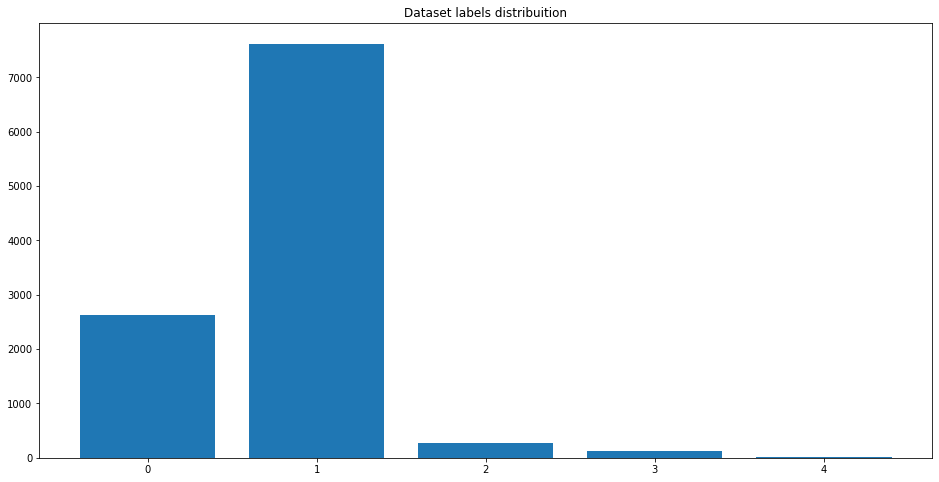

In [6]:
label_cnt = Counter(df.label)

plt.figure(figsize=(16,8))
plt.bar(label_cnt.keys(), label_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [7]:
stop_words = stopwords.words("indonesian")
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [8]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [9]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 1.17 s
Wall time: 1.21 s


### Split train and test

In [10]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=0)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 9584
TEST size: 1065


### Tokenizer

In [11]:
all_words=' '.join(df_train.text)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)
num_unique_word=len(dist)
num_unique_word

9823

In [12]:
r_len=[]
for text in df_train.text:
    word=word_tokenize(text)
    l=len(word)
    r_len.append(l)
    
MAX_REVIEW_LEN=np.max(r_len)
MAX_REVIEW_LEN

27

In [13]:
max_features = num_unique_word
max_words = MAX_REVIEW_LEN
batch_size = 1024
epochs = 12
num_classes=5

In [14]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df_train.text))

In [15]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=max_words)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=max_words)
print(x_train.shape,x_test.shape)

(9584, 27) (1065, 27)
CPU times: total: 172 ms
Wall time: 166 ms


In [16]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (9584, 1)
y_test (1065, 1)


In [17]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (9584, 27)
y_train (9584, 1)

x_test (1065, 27)
y_test (1065, 1)


In [18]:
y_train[:10]

array([[0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

## Glove

In [19]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features,embed_dim):
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return embedding_matrix

In [20]:
# embedding matrix
EMBEDDING_FILE = 'D:/NLP/Dataset/glove.6B.100d.txt'
embed_dim = 100 #word vector dim
embedding_matrix = get_embed_mat(EMBEDDING_FILE,max_features,embed_dim)
print(embedding_matrix.shape)

Found 400000 word vectors.
(9823, 100)


In [21]:
embedding_layer = Embedding(max_features, embed_dim, input_length=MAX_REVIEW_LEN,trainable=False)

### Build Model

In [22]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 100)           982300    
                                                                 
 conv1d (Conv1D)             (None, 27, 128)           51328     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 32)            8

### Compile model

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [24]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Train

In [25]:
%%time
history=model.fit(x_train, y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  verbose=1,
                  validation_split=0.1,
                  callbacks=callbacks)

Epoch 1/12
9/9 [==============================] - 3s 235ms/step - loss: 0.5819 - accuracy: 0.7068 - val_loss: 0.4778 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 2/12
9/9 [==============================] - 2s 204ms/step - loss: 0.4108 - accuracy: 0.7155 - val_loss: 0.3140 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 3/12
9/9 [==============================] - 2s 206ms/step - loss: 0.2756 - accuracy: 0.7303 - val_loss: 0.2305 - val_accuracy: 0.8603 - lr: 0.0010
Epoch 4/12
9/9 [==============================] - 2s 206ms/step - loss: 0.1991 - accuracy: 0.8412 - val_loss: 0.1839 - val_accuracy: 0.8676 - lr: 0.0010
Epoch 5/12
9/9 [==============================] - 2s 220ms/step - loss: 0.1247 - accuracy: 0.8492 - val_loss: 0.1274 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 6/12
9/9 [==============================] - 2s 209ms/step - loss: -0.0136 - accuracy: 0.8543 - val_loss: 0.0698 - val_accuracy: 0.8728 - lr: 0.0010
Epoch 7/12
9/9 [==============================] - 2s 209ms/step - loss: -0.3349 -

### Evaluate

In [26]:
%%time
score = model.evaluate(x_test, y_test, batch_size=batch_size)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

2/2 [==============================] - 0s 8ms/step - loss: -86.8346 - accuracy: 0.8394

ACCURACY: 0.8394365906715393
LOSS: -86.83464050292969
CPU times: total: 359 ms
Wall time: 167 ms


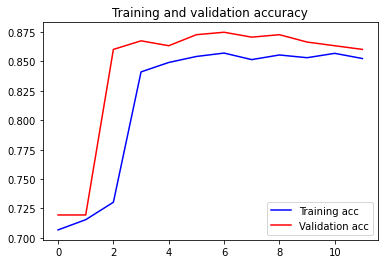

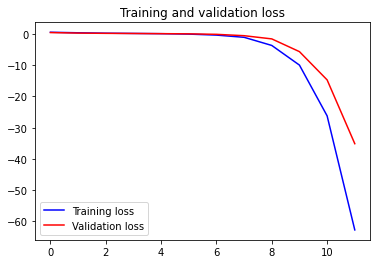

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Confusion Matrix

In [28]:
import seaborn as sns

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Happy','Angry','Sad','Fear','Suprised']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

34/34 [==============================] - 0s 5ms/step


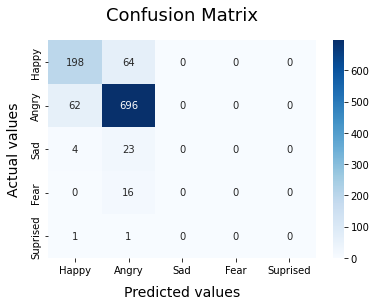

In [29]:
# Predicting on the Test dataset.
y_pred = model.predict(x_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

### Classification Report

In [30]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7472    0.7557    0.7514       262
           1     0.8700    0.9182    0.8935       758
           2     0.0000    0.0000    0.0000        27
           3     0.0000    0.0000    0.0000        16
           4     0.0000    0.0000    0.0000         2

    accuracy                         0.8394      1065
   macro avg     0.3234    0.3348    0.3290      1065
weighted avg     0.8030    0.8394    0.8208      1065



### Accuracy Score

In [31]:
accuracy_score(y_test, y_pred)

0.8394366197183099

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)